In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os
import matplotlib.pyplot as plt


In [8]:
BASE_DIR = r"F:\Multimodal_Emotion_Detection\data\image\fer2013"

train_dir = os.path.join(BASE_DIR, "train")
test_dir = os.path.join(BASE_DIR, "test")

print("Train directory:", train_dir)
print("Test directory:", test_dir)


Train directory: F:\Multimodal_Emotion_Detection\data\image\fer2013\train
Test directory: F:\Multimodal_Emotion_Detection\data\image\fer2013\test


In [9]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [10]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

# Number of emotion classes
NUM_CLASSES = train_data.num_classes  

# Load MobileNetV2 (pretrained)
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base layers (so training is faster)
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
preds = Dense(NUM_CLASSES, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=preds)

# Compile
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,266,951 (8.65 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


In [11]:
class_weights = {0: 1.03, 1: 9.41, 2: 1.00, 3: 0.57, 4: 0.83, 5: 0.85, 6: 1.29}


In [12]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=10,
    class_weight=class_weights  # <- here is the balancing
)


Epoch 1/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 1747s 2s/step - accuracy: 0.2612 - loss: 1.9460 - val_accuracy: 0.3383 - val_loss: 1.6831
Epoch 2/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 1377s 2s/step - accuracy: 0.3023 - loss: 1.8030 - val_accuracy: 0.3512 - val_loss: 1.6613
Epoch 3/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 1435s 2s/step - accuracy: 0.3175 - loss: 1.7609 - val_accuracy: 0.4090 - val_loss: 1.5484
Epoch 4/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 1438s 2s/step - accuracy: 0.3235 - loss: 1.7609 - val_accuracy: 0.3695 - val_loss: 1.6529
Epoch 5/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 1407s 2s/step - accuracy: 0.3229 - loss: 1.7593 - val_accuracy: 0.3877 - val_loss: 1.5751
Epoch 6/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 1011s 1s/step - accuracy: 0.3273 - loss: 1.7401 - val_accuracy: 0.4075 - val_loss: 1.5326
Epoch 7/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 1075s 1s/step - accuracy: 0.3262 - loss: 1.7465 - val_accuracy: 0.3732 - val_loss: 1.6355
Epoch 8/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 988s 1s/step - accuracy: 0.3242 - loss: 1.7433 - v

In [13]:
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 166s 737ms/step - accuracy: 0.3487 - loss: 1.6780
Test Accuracy: 0.3487
Test Loss: 1.6780


In [14]:
model.save("mobilenetv2_emotion_base.h5")
print("Model saved successfully!")


Model saved successfully!


In [15]:
model.save('my_model.keras')
print('model saved successfully')

model saved successfully


In [16]:
for layer in base_model.layers[-40:]:
    layer.trainable = True


In [17]:
model.compile(
    optimizer=Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [18]:
history_ft = model.fit(
    train_data,
    validation_data=test_data,
    epochs=10
)


Epoch 1/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 1812s 2s/step - accuracy: 0.3246 - loss: 1.8299 - val_accuracy: 0.4184 - val_loss: 1.5286
Epoch 2/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 1834s 2s/step - accuracy: 0.3952 - loss: 1.5609 - val_accuracy: 0.4362 - val_loss: 1.5039
Epoch 3/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 1888s 2s/step - accuracy: 0.4309 - loss: 1.4753 - val_accuracy: 0.4698 - val_loss: 1.4136
Epoch 4/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 2021s 2s/step - accuracy: 0.4593 - loss: 1.4100 - val_accuracy: 0.4784 - val_loss: 1.3904
Epoch 5/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 2033s 2s/step - accuracy: 0.4774 - loss: 1.3631 - val_accuracy: 0.4914 - val_loss: 1.3741
Epoch 6/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 2570s 3s/step - accuracy: 0.4912 - loss: 1.3279 - val_accuracy: 0.5155 - val_loss: 1.2931
Epoch 7/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 1984s 2s/step - accuracy: 0.5026 - loss: 1.2998 - val_accuracy: 0.5171 - val_loss: 1.2771
Epoch 8/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 1823s 2s/step - accuracy: 0.5124 - loss: 1.2752 - 

In [19]:
model.save("02mobilenetv2_emotion_base.h5")
print('saved succesfully')


saved succesfully


In [20]:
model.save('02my_model.keras')

In [18]:
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np

model_image = load_model("02mobilenetv2_emotion_base.h5")

EMOTIONS = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

def preprocess_image(img_path):
    img = Image.open(img_path).convert("L")
    img = img.resize((224, 224))
    img = np.stack((img,) * 3, axis=-1)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

def predict_image_emotion(img_path):
    img = preprocess_image(img_path)
    preds = model_image.predict(img)[0]
    label = EMOTIONS[np.argmax(preds)]
    confidence = np.max(preds)
    print(f"Predicted Emotion: {label} ({confidence:.2f})")
    return label, confidence


In [12]:
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


225/225 ━━━━━━━━━━━━━━━━━━━━ 435s 2s/step - accuracy: 0.5444 - loss: 1.2009
Test Accuracy: 0.5444
Test Loss: 1.2009


In [13]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Get true labels
y_true = test_data.classes

# Step 2: Predict
y_pred_prob = model.predict(test_data)
y_pred = np.argmax(y_pred_prob, axis=1)

# Step 3: Get class labels
class_labels = list(test_data.class_indices.keys())


225/225 ━━━━━━━━━━━━━━━━━━━━ 188s 818ms/step


In [14]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


Classification Report:
              precision    recall  f1-score   support

       angry       0.15      0.13      0.14       958
     disgust       0.00      0.00      0.00       111
        fear       0.16      0.04      0.07      1024
       happy       0.25      0.29      0.27      1774
     neutral       0.17      0.19      0.18      1233
         sad       0.17      0.22      0.19      1247
    surprise       0.12      0.14      0.13       831

    accuracy                           0.18      7178
   macro avg       0.15      0.14      0.14      7178
weighted avg       0.18      0.18      0.17      7178



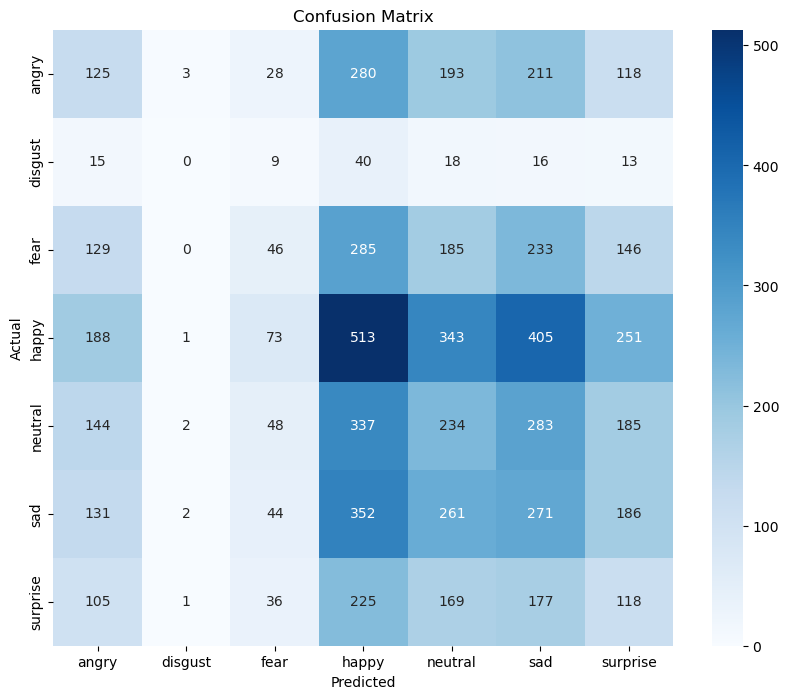

In [19]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [33]:
import json

with open("class_labels.json", "w") as f:
    json.dump(class_labels, f)

print("Class labels saved!")


Class labels saved!


In [34]:
with open("class_labels.json") as f:
    class_labels = json.load(f)


In [15]:
globals().keys()

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', 'open', '_', '__', '___', '__vsc_ipynb_file__', '_i', '_ii', '_iii', '_i1', 'tf', 'ImageDataGenerator', 'MobileNetV2', 'Dense', 'GlobalAveragePooling2D', 'Dropout', 'Model', 'Adam', 'os', 'plt', '_i2', 'load_model', 'model', '_i3', '_i4', '_4', '_i5', '_i6', '_i7', '_i8', 'BASE_DIR', 'train_dir', 'test_dir', '_i9', 'IMAGE_SIZE', 'BATCH_SIZE', 'train_datagen', 'test_datagen', 'train_data', 'test_data', '_i10', 'NUM_CLASSES', 'base_model', 'layer', 'x', 'preds', '_i11', '_i12', 'test_loss', 'test_acc', '_i13', 'np', 'classification_report', 'confusion_matrix', 'sns', 'y_true', 'y_pred_prob', 'y_pred', 'class_labels', '_i14', '_i15'])

In [20]:
predict_image_emotion(r'F:\Multimodal_Emotion_Detection\data\image\fer2013\test\disgust\PrivateTest_4396496.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Emotion: neutral (0.42)


('neutral', np.float32(0.42310694))